In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
import copy
from matplotlib import animation, rc
from IPython.display import HTML
from skimage.measure import label, regionprops

#Load a special color map which helps us view labels
num_classes = 255
GLASBEYLUT = 'glasbey.lut'
glasbey_lut = (np.loadtxt(GLASBEYLUT, dtype=np.float) / 255.0)[:,1:]
cmap = mpl.colors.ListedColormap (glasbey_lut,'Glasbey',num_classes)
norm = mpl.colors.Normalize(vmin=0, vmax=num_classes)

rc('animation', html='html5')

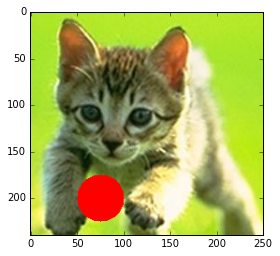

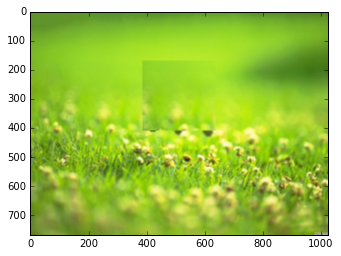

In [10]:
img = cv2.imread('kittens/cat-jumping-running-grass.jpg')
img = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

kitty = copy.deepcopy(img[170:410,385:635,:])
#Give the kitty a red ball
cv2.circle(kitty,(75,200),radius=25,color=(255,0,0),thickness=-1)
fig = plt.figure()
plt.imshow(kitty)

fig2 = plt.figure()
no_kitty = copy.deepcopy(img)
no_kitty[170:410,385:635,:] = no_kitty[170:410,135:385,:]
no_kitty = cv2.blur(no_kitty,(7,7))
plt.imshow(no_kitty)


Ball centroid = (200.0, 75.0)


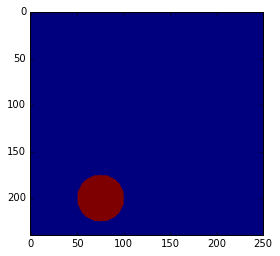

In [11]:
#This shows a simple example of how to detect the ball based on its color
#This is a trivial example - it wouldn't do well with lighting changes
#or other forms of noise

lower_red_boundary = np.array([200,0,0],dtype=np.uint8)
upper_red_boundary = np.array([255,20,20],dtype=np.uint8)

ball_mask = cv2.inRange(kitty,lower_red_boundary,upper_red_boundary)
plt.imshow(ball_mask)

ball_centroid = np.array([0,0])
detected = False
# circle area is pi*25^2 = 1963, so threshold at 1500
regions = regionprops(ball_mask)
for props in regions:
  #Eccentricity of 0 is a circle
  if (props.area > 1500 and props.eccentricity < 0.3):
    ball_centroid = props.centroid
    detected = True
    break
    
print ("Ball centroid = {}".format(ball_centroid))

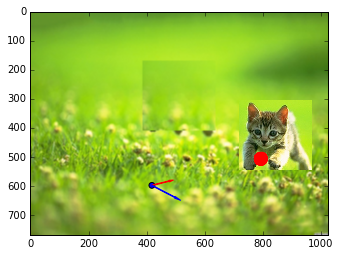

In [21]:
#Set this to about 100, or it will take a LONG time to compile the animation.
#500 takes about 10 minutes - mainly because matplotlib drawing is slooow.
num_frames = 150
fig, ax = plt.subplots()

MAX_TURN = np.radians(3)

class AttentionAnim(object):
    def __init__(self):
        #This sets up the kitty position and variables
        self.kitty_pos = np.array([no_kitty.shape[0]/2.0, no_kitty.shape[1]/2.0])
        self.kitty_vel = np.array([5,5])
        self.rows,self.cols = no_kitty.shape[0:2]
        self.h,self.w = kitty.shape[0:2]
        
        #Set up position of tracker
        self.pos = np.array([0,0])
        self.circle = mpl.patches.Circle((self.pos[1],self.pos[0]),radius=10,fill=True)
        ax.add_patch(self.circle)
        
        #Set up velocity vector
        self.vel = np.array([5,0])
        self.vel_arrow = mpl.patches.Arrow (self.pos[1],self.pos[0],10*self.vel[1],10*self.vel[0],width=10,color='b')
        ax.add_patch(self.vel_arrow)
  
        #Set up arrow pointing bearing to target
        self.sight_bearing = np.array([0,0])
        self.sight_arrow = mpl.patches.Arrow (self.pos[1],self.pos[0],self.sight_bearing[1],self.sight_bearing[0],width=10,color='r')
        ax.add_patch(self.sight_arrow)
        
        #Proportional Gain
        self.Kp=0.03
        #Integration Gain
        self.Ki=0
        #Derivative Gain
        self.Kd=0
        
        #initialize ball detection
        self.ball_centroid = np.array([0,0])
        
    def step_kitty(self):
        #Check if kitty will go out of image, and if so, mirror it's velocity
        if (self.kitty_pos[0]+self.kitty_vel[0]+self.h >= self.rows or self.kitty_pos[0]+self.kitty_vel[0] <= 0 ):
          self.kitty_vel[0] *= -1
        if (self.kitty_pos[1] + self.kitty_vel[1]+self.w >= self.cols or self.kitty_pos[1] + self.kitty_vel[1] <= 0):
          self.kitty_vel[1] *= -1
        #Update kitty position
        self.kitty_pos = self.kitty_pos+self.kitty_vel
        #Randomly adjust kitty velocity
        self.kitty_vel = self.kitty_vel + 3*(0.5 - np.random.rand(2))
       
    def step_follower(self):
        #Remove the previous time step, update position by velocity from previous timestep
        self.circle.remove()
        self.pos = self.pos + self.vel
        self.circle = mpl.patches.Circle((self.pos[1],self.pos[0]),radius=10,fill=True)
        ax.add_patch(self.circle)
        
    def update_bearing(self):
        #Remove previous desired bearing vector, replace with new kitty position
        estimated_kitty_pos = self.detect_kitty()
        self.sight_bearing = estimated_kitty_pos - self.pos
        #This cheats and uses Ground Truth kitty position
        #self.sight_bearing = (self.kitty_pos+np.array([self.h/2,self.w/2])) - self.pos
        
        #Normalize bearing vector
        self.sight_arrow.remove()
        self.sight_arrow = mpl.patches.Arrow (self.pos[1],self.pos[0],0.2*self.sight_bearing[1],0.2*self.sight_bearing[0],width=10,color='r')
        ax.add_patch(self.sight_arrow)
        
    def detect_kitty (self):
        #This detects the position of the kitty's red ball
        lower_red_boundary = np.array([200,0,0],dtype=np.uint8)
        upper_red_boundary = np.array([255,20,20],dtype=np.uint8)

        ball_mask = cv2.inRange(self.current_img,lower_red_boundary,upper_red_boundary)

        # circle area is pi*25^2 = 1963, so threshold at 1500
        regions = regionprops(ball_mask)
        for props in regions:
          #Eccentricity of 0 is a circle
          if (props.area > 1500 and props.eccentricity < 0.3):
            self.ball_centroid = props.centroid
            return self.ball_centroid
        
        #If we didn't detect the ball, just use old position
        return self.ball_centroid
        
        
    
    def update_velocity(self):
        #Compute error (distance to target)
        error = np.linalg.norm(self.sight_bearing)
        #Subtract small value so we never cross over the target (this is small because it's in pixels)
        error = error - 10
        
        #Compute Integration Input
        
        #Compute Derivative Input
        
        # Calculate control input for the system
        u = (self.Kp * (error))
        self.vel = u * self.vel/np.linalg.norm(self.vel)
        
        #Normalize the bearing vector
        self.sight_bearing =  self.sight_bearing / (np.linalg.norm(self.sight_bearing))
        dotp = self.vel.dot(self.sight_bearing)
        normval = np.linalg.norm(self.vel) * np.linalg.norm(self.sight_bearing)
        
        theta = np.arccos(np.clip(dotp/normval, -1.0, 1.0))
        
        #Calculate direction of rotation
        cross_prod = np.cross(np.append(self.vel,[0]),np.append(self.sight_bearing,[0]))
        sign = cross_prod.dot(np.array([0,0,1]))
        #To avoid getting trapped with target behind, always rotate one 
        #direction if angle is large
        if (theta > np.radians(120)):
          sign = 1
        theta = np.sign(sign) * theta
        
        #Clip to max rotation angle - corresponds to max turn angle
        theta = np.clip (theta, -1*MAX_TURN, MAX_TURN)
        rotMat =  np.array([[np.cos(theta), -np.sin(theta)], 
                                 [np.sin(theta),  np.cos(theta)]])
        
        #Rotate by the current rotation angle
        self.vel =  rotMat.dot(self.vel)
        self.vel_arrow.remove()
        self.vel_arrow = mpl.patches.Arrow (self.pos[1],self.pos[0],10*self.vel[1],10*self.vel[0],width=10,color='b')
        ax.add_patch(self.vel_arrow)
        
    def plot_step(self,i):
        #Move the kitty
        self.step_kitty()
        #Update the image of the kitty
        self.current_img = copy.deepcopy(no_kitty)  
        self.current_img [int(self.kitty_pos[0]):int(self.kitty_pos[0]+self.h),int(self.kitty_pos[1]):int(self.kitty_pos[1]+self.w),:] = kitty
        ax.imshow(self.current_img )
        
        #Move the follower
        self.step_follower()
        #Take a new estimate of kitty bearing
        self.update_bearing()
        #Turn towards the new kitty bearing
        self.update_velocity()

        return

animObj = AttentionAnim()
anim = animation.FuncAnimation(fig, animObj.plot_step,frames=num_frames, interval=50)

anim

In [4]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, bitrate=10000)

#this saves the animation file
animObj = AttentionAnim()
anim = animation.FuncAnimation(fig, animObj.plot_step,frames=num_frames, interval=50)
anim.save('visual_servo_example.mp4', writer=writer)

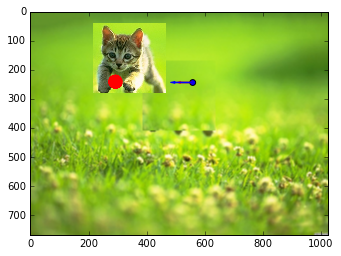

In [20]:
fig, ax = plt.subplots()

#This shows the animation for num_frames = 300, which took a (long) while to generate
num_frames = 300
animObj = AttentionAnim()
anim = animation.FuncAnimation(fig, animObj.plot_step,frames=num_frames, interval=50)

anim